# Actividad laboratorio: Estimación de parámetros de un activo financiero

## Objetivos

El objetivo de esta actividad es programar y así tener soltura a la hora de manejar datos financieros.

## Pautas de elaboración

En uno de los recursos audiovisuales se ha explicado como ir a una base de datos donde aparecen las cotizaciones de las grandes empresas en el IBEX-35. En primer lugar, se recomienda considerar un activo, descargarse los datos y ajustar los parámetros del modelo log-normal utilizando dos de los tres métodos de estimación que se explican en el Tema 6.

## Parte 1: Definición de las funciones que vamos a utilizar y carga de librerías

En python hay multitud de librerías que podemos utilizar, en este caso utilizaremos librerías standar para el analísis de datos y acceder a la base de datos de Yahoo Finance.
Además, vamos a definir una serie de funciones para proceder a ajustar un modelo log-normal.

El modelo Log-Normal se puede describir matemáticamente como:
$$ 
    \begin{cases}
    dS(t) = \mu S(t) + \sigma S(t)dW(t)\ \ donde \  \mu \in \mathbb{R} \ y \ \sigma >0, \\
    S(0) = s_0
    \end{cases} 
$$
Aplicando el Lema de Ito y resolviendo la EDE, obtenemos que $S(t) = s_0 \cdot e^{(\mu - \frac{1}{2}\sigma ^2)t + \sigma W(t) }$

### Librerías

In [14]:
#pip install yfinance   -> Con esta librería podemos conectarnos a los datos de Yahoo Finance.
#pip install pandas     -> Librería por excelencia para el manejo de DataFrames con python.
#pip install numpy      -> Librería por excelencia para el manejo de arrays de datos con python.
#pip install mplfinance -> Librería para hacer candle plots.
#pip install math       -> Librería por excelencia para utilizar funciones matemáticas.
#pip install datetime   -> Librería por excelencia para manejar timestamps.
#pip install matplotlib.pyplot -> Librería por excelencia para graficar.

import yfinance as yf  
import pandas as pd 
import numpy as np
import mplfinance as mpf
import datetime as dt
from math import exp

import matplotlib.pyplot as plt

### Funciones

####  Media

Aplicando el operador esperanza se obtiene la siguiente expresión: $$ \mathbb{E}[S(t)] = s_0 \cdot e^{\mu t}, $$ Esto lo podemos programar de la siguiente manera:

In [106]:
def media(datos,mu,t = None):
    """
    La siguiente función nos devuelve el media del modelo Log-Normal en el instate t:
    Input:
        - datos(List[Number])   : Datos a analizar.
        - mu(Number)            : Media muestral.
        - t (Number)            : Vector de tiempos o el instante t. (Valor opcional, si no se rellena, devuelve en cada instante de t)
    Output:
        - eS(List[Number])      : Vector de medias de la solución en todos los instantes o media de la solución en el instante t.
    """
    from math import exp
    s0 = datos[0]
    eS = []
    if t:
        eS.append(s0*exp(mu*t))
    else:
        for t in range(len(datos)):
            eS.append(s0*exp(mu*(t)))
    return(eS)

#### Desviación típica

Podemos calcular la desviación típica de la siguiente manera: $$ \sqrt{ \mathbb{V}[S(t)]} = \sqrt{\mathbb{E}[S(t)^2] - \mathbb{E}[S(t)]^2 }= \sqrt{ s_0^2 \cdot e^{2 \mu t} \cdot (e^{\sigma^2 t} - 1)}, $$ Esto lo podemos programar de la siguiente manera:

In [136]:
def desvTipica(datos,mu, sigma, t = None):
    """
    La siguiente función nos devuelve la desviación típica del modelo Log-Normal en el instate t:
    Input:
        - datos(List[Number])   : Datos a analizar.
        - mu(Number)            : Media muestral.
        - sigma(Number)         : Desviación típica muestral.
        - t (Number)            : Vector de tiempos o el instante t. (Valor opcional, si no se rellena, devuelve en cada instante de t)
    Output:
        - eS(List[Number])       : Vector desviación típica la solución en todos los instantes o desviación típica de la solución en el instante t.
    """
    from math import exp, sqrt
    import numpy as np 
    s0 = datos[0]
    eS = []
    if t:
        eS.append(sqrt(((s0**2)*exp(2*mu*t))*(exp((sigma**2)*t)-1)))
    else:
        for t in range(len(datos)):
            eS.append(sqrt(((s0**2)*exp(2*mu*t))*(exp((sigma**2)*t)-1)))
    return(eS)

#### Método de estimación de momentos estadísticos

In [46]:
def estimacionMomentos(datos):
    """
    La siguiente función nos devuelve mu y sigma obtenidos por el método de los momentos,
    Este método se basa en calcular la media y varianza muestral de la diferencia de logaritmos de nuestros datos, es decir,
    la diferencia de S(t) evaluado en i+1 e i tomando logaritmos. Con esta diferencia obtenemos los valores que nos da el método:
    Input:
        - datos(List[Number])   : Datos a analizar.
    Output:
        - Dict[Number]          : Diccionario con los datos de la media y la desviación típica que nos da el método.
    """
    import numpy as np
    import pandas as pd
    import datetime as dt

    try:
        dt = (datos.index[1] - datos.index[0]).days
        u = np.log(datos).diff()
        uM = u.mean()
        uV = u.std()**2
        
        return( {"mMME" : (uM + uV/2)/dt , "sMME" : np.sqrt(uV/dt) }   )
    except:
        dt = 1
        u = np.log(datos).diff()
        uM = u.mean()
        uV = u.std()**2
        
        return( {"mMME" : (uM + uV/2)/dt , "sMME" : np.sqrt(uV/dt) }   )

#### Método de estimación de máxima verosimilitud

In [41]:
def estimacionMV(datos):
    """
    La siguiente función nos devuelve mu y sigma obtenidos por el método de máxima verosimilitud,
    Este método se basa en maximizar la función de verosimilitud.
    Input:
        - datos(List[Number])   : Datos a analizar.
    Output:
        - Dict[Number]          : Diccionario con los datos de la media y la desviación típica que nos da el método.
    """
    import numpy as np
    import pandas as pd
    import datetime as dt
    n = len(datos)
    try:
        dt = (datos.index[1] - datos.index[0]).days

        muE = (1/(n*dt))*np.sum((datos/datos.shift()) -1)
        siE = np.sqrt((1/(n*dt))*np.sum(((datos/datos.shift()) -1- muE*dt)**2 ))
        
        return( {"muE" : muE  ,"siE" : siE})
    except:
        dt = 1

        muE = (1/(n*dt))*np.sum((datos/datos.shift()) -1)
        siE = np.sqrt((1/(n*dt))*np.sum(((datos/datos.shift()) -1- muE*dt)**2 ))
        
        return( {"muE" : muE  ,"siE" : siE})

#### Método de estimación de momentos no paramétrico

In [43]:
def estimacionMNP(datos):
    """
    La siguiente función nos devuelve mu y sigma obtenidos por el método de momentos no paramétrico.
    Input:
        - datos(List[Number])   : Datos a analizar.
    Output:
        - Dict[Number]          : Diccionario con los datos de la media y la desviación típica que nos da el método.
    """
    import numpy as np
    import pandas as pd
    import datetime as dt
    n = len(datos)
    
    try:
        dt = (datos.index[1] - datos.index[0]).days
        muE = (1/(dt))*(np.sum(datos.diff())/np.sum(datos[0:(n-1)]))
        siE = np.sqrt((1/(dt))*(np.sum((datos.diff())**2)/np.sum((datos[0:(n-1)])**2)))
        
        return( {"muE" : muE  ,"siE" : siE})
    except:
        dt = 1

        muE = (1/(dt))*(np.sum(datos.diff())/np.sum(datos[0:(n-1)]))
        siE = np.sqrt((1/(dt))*(np.sum((datos.diff())**2)/np.sum((datos[0:(n-1)])**2)))
        
        return( {"muE" : muE  ,"siE" : siE})

#### Errores

In [73]:
def errores(datos, modelo):
    import numpy as np
    import pandas as pd

    d = np.log(datos[0])
    m = np.log(modelo)

    n = len(datos)

    ecm = np.sqrt((1/n)*(np.sum( (d-m)**2 )) )

    mape = 100/n * np.sum(np.abs(d-m)/np.abs(d))

    return({"ECM": ecm , "MAPE" : mape})

#### Validación del modelo

In [66]:
def validacion(estimacion, datos):
    mu = [estimacion[k] for k in estimacion.keys() if k in ("mMME","muE","muE")][0]
    sigma = [estimacion[k] for k in estimacion.keys() if k not in ("mMME","muE","muE")][0]

    mm = media(datos,mu)

    return(errores(datos, mm))

#### Predicciones

In [152]:
def predecir(datos, est, t):
    mu = [est[k] for k in est.keys() if k in ("mMME","muE","muE")][0]
    sigma = [est[k] for k in est.keys() if k not in ("mMME","muE","muE")][0]

    val = validacion(est, datos)

    muP = media(datos,mu)
    for i in range(0,t):
        muP.append(media(datos,mu,len(datos)+i)[0])

    sigmaP = desvTipica(datos,mu, sigma)
    for i in range(0,t):
        sigmaP.append(desvTipica(datos,mu,sigma,len(datos)+i)[0])


    p25 = np.array(muP)-1.96*np.array(sigmaP)
    p975 = np.array(muP) + 1.96*np.array(sigmaP)

    tabla = pd.DataFrame([p25,muP,p975,sigmaP]).transpose()
    tabla.columns = ["IC 95% Inf", "Media", "IC 95% Sup" , "Desv Tipica"]
    print( f"ECM -> {round(val['ECM'],4)}\nMAPE -> {round(val['MAPE'],4)}%\nPrediccion a {t} días.")
    return(tabla)

#### Gráficos

In [178]:
def graficar(datos, est, t):
    tabla = predecir(datos, est, t)
    print(tabla.tail(t))

    plt.plot(datos, label = "Datos")
    plt.plot(tabla[["IC 95% Inf"]], label = "IC 95% Inf")
    plt.plot(tabla[["Media"]], label = "Media")
    plt.plot(tabla[["IC 95% Sup"]], label = "IC 95% Sup")
    plt.axvline(x = len(datos)-1 , color = 'black') 
    plt.legend()
    plt.show()

## Parte 2: Análisis exploratorio de los datos

En esta segunda parte, vamos a analizar de forma libiana los datos y en caso de necesitar alguna transformación para poder aplicar nuestro modelo procederemos con ello.

En primer lugar, establecemos la conexión con la base de datos de Yahoo Finance y vamos a descargar los datos del BBVA, es una empresa que opera en el sector retail bancario, lo que significa que ofrecen servicios como cuentas de ahorro, tarjetas de débito/crédito, productos de inversión, etc.

En la siguiente tabla, podemos ver los valores de los ultimos días de apertura y cierre, el valor máximo/mínimo en el día.

In [180]:
simbolo = "BBVA.MC"
bbva = yf.Ticker(simbolo)
print(bbva.info["longBusinessSummary"] + " " + bbva.info["website"])
df = bbva.history(period="max")
df[["Open", "High", "Low","Close"]].tail(10)

Banco Bilbao Vizcaya Argentaria, S.A., together with its subsidiaries, provides retail banking, wholesale banking, and asset management services. It offers current accounts; and demand, savings, overnight, time, term, and subordinated deposits. The company also provides loan products; deals in securities; and manages pension and investment funds. In addition, it offers credit cards; corporate and investment banking services; insurance products and services; and real estate services. The company provides its products through online and mobile channels. As of December 31, 2021, it operated through a network of 6,083 branches and 29,148 ATMs. It operates in Spain, Mexico, South America, the United States, Turkey, Asia, and rest of Europe. Banco Bilbao Vizcaya Argentaria, S.A. was founded in 1857 and is headquartered in Bilbao, Spain. https://www.bbva.com


,Open,High,Low,Close
Date,,,,
2022-10-25 00:00:00+02:00,5.204,5.265,5.134,5.230
2022-10-26 00:00:00+02:00,5.269,5.290,5.183,5.221
2022-10-27 00:00:00+02:00,5.206,5.258,5.127,5.258
2022-10-28 00:00:00+02:00,5.197,5.248,5.021,5.246
2022-10-31 00:00:00+01:00,5.240,5.272,5.172,5.209
2022-11-01 00:00:00+01:00,5.249,5.299,5.229,5.255
2022-11-02 00:00:00+01:00,5.298,5.333,5.261,5.286
2022-11-03 00:00:00+01:00,5.253,5.253,5.154,5.227
2022-11-04 00:00:00+01:00,5.285,5.338,5.227,5.304


Como vemos el conjunto de datos proporcionado en el índice del DataFrame tenemos la fecha en formato, año, mes, días y hora. Depués tenemos valores numéricos, como son el valor de apertura, el máximo, el mínimo y el cierre. En el siguiente gráfico, podemos ver los precios del BBVA desde el año 2000, se aprecia que al rededor del año 2006 obtuvo sus valores máximo y al rededor de los años 2008 y 2020 los valores mínimos, esto es algo que tiene sentido, ya que ambos momentos se estaba atravesando una crísis económica.

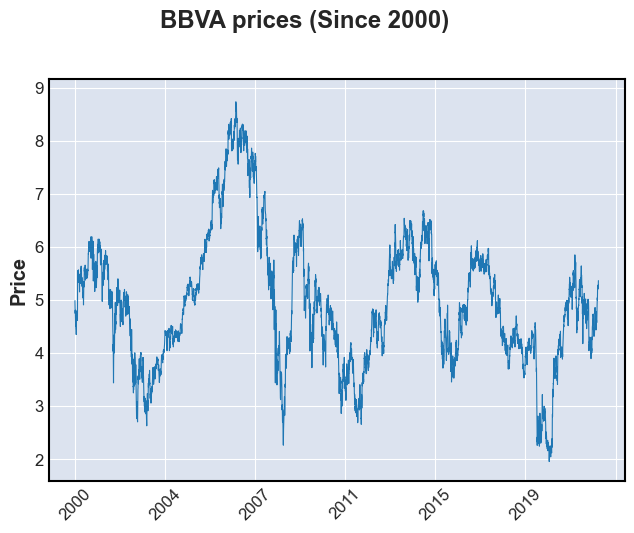

None

In [181]:
display(mpf.plot(df,type='line', title = "BBVA prices (Since 2000)", datetime_format = "%Y"))

Si nos fijamos en los valores tomados en los últimos 120 días, podemos ver como la tendencia desde mitad del mes de Junio es creciente y positiva, aunque no en todo el periodo ha sido así.

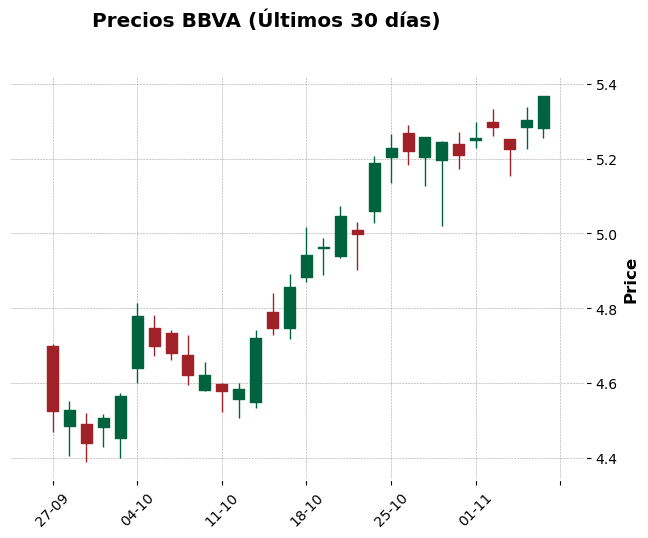

None

In [184]:
display(mpf.plot(df.iloc[len(df)-30:] ,type='candle', title = "Precios BBVA (Últimos 30 días)", datetime_format = "%d-%m" , style = "charles"))

## Parte 3: Modelo Log-Normal

En primer lugar, vamos a tomar un subconjunto de los datos, por ejemplo los ultimos 30 días. Además, solo cogeremos los datos de cierre.

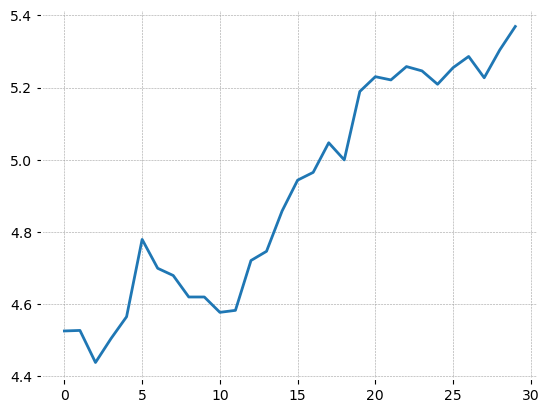

In [206]:
datos = df.iloc[len(df)-30:]["Close"]
datos.index = range(0,len(datos))
datos.plot()
plt.show()

Como habíamos apreciado, tenemos una tendencia claramente positiva. Ahora vamos a calcular los estimadores para nuestra muestra de datos y eligiremos el mejor en función del error que presente.

### Cálculo de estimadores

Con las funciones definidas al principio del ejercicio, podemos calcular los tres principales estimadores, el de momentos, máxima verosimilitud y momentos no paramétrico.

In [207]:
estimacionMomentos(datos)

{'mMME': 0.006010210985811143, 'sMME': 0.01549039964312536}

In [208]:
estimacionMV(datos)

{'muE': 0.0058237092796276126, 'siE': 0.015131127933926907}

In [209]:
estimacionMNP(datos)

{'muE': 0.005944304508464831, 'siE': 0.016082077515365282}

### Validación

Vamos que los resultados son bastante similares, aunque para saber con exactitud cual se ajusta mejor a nuestros datos, vamos a utilizar proceder a validarlos mediante el estudio del error cuadrático medio y el error absoluto porcentual.

In [210]:
validaciones = pd.DataFrame([validacion(estimacionMomentos(datos), datos),
                                validacion(estimacionMV(datos), datos),
                                validacion(estimacionMNP(datos), datos)] , index = ["M", "MV", "MNP"] )
display(validaciones)

,ECM,MAPE
M,0.101494,5.772064
MV,0.098344,5.592952
MNP,0.100381,5.708769


Si nos fijamos en la tabla, vemos como el mejor resultado lo obtiene el método de máxima verosimilitud, por lo que será el que utilicemos a la hora de ajustar nuestro modelo.

### Ajuste del modelo

ECM -> 0.0983
MAPE -> 5.593%
Prediccion a 5 días.
    IC 95% Inf     Media  IC 95% Sup  Desv Tipica
30    4.512911  5.389950    6.266989     0.447469
31    4.524636  5.421431    6.318226     0.457549
32    4.536577  5.453096    6.369615     0.467612
33    4.548727  5.484946    6.421165     0.477663
34    4.561078  5.516982    6.472886     0.487706


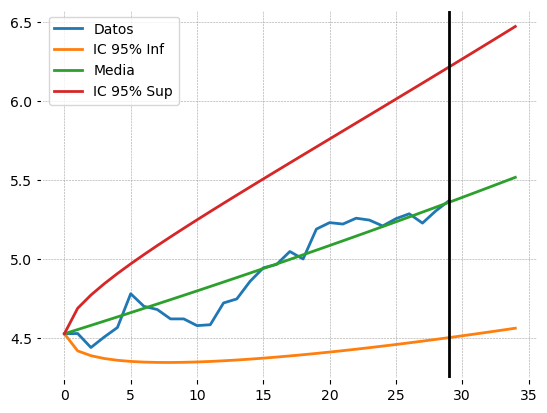

In [211]:
graficar(datos, estimacionMV(datos), 5)